In [1]:
import glob
import math

import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

images_path = "./images/"

# Preprocesado  
Leemos la imagen y la preparamos para la extracción de información.
Necesitaremos el clásico suavizado gaussiano

In [2]:
def gaussian_smoothing(image, sigma, w_kernel):
    s = sigma
    w = w_kernel
    kernel_1D = np.array(
        np.float32(
            [
                (1 / (s * np.sqrt(2 * np.pi))) * np.exp(-((z * z) / (2 * s * s)))
                for z in range(-w, w + 1)
            ]
        )
    )

    # Apply distributive property of convolution
    vertical_kernel = kernel_1D.reshape(2 * w + 1, 1)
    horizontal_kernel = kernel_1D.reshape(1, 2 * w + 1)
    gaussian_kernel_2D = signal.convolve2d(vertical_kernel, horizontal_kernel)
    # Blur image
    smoothed_img = cv2.filter2D(image, cv2.CV_8U, gaussian_kernel_2D)
    # Normalize to [0 254] values
    smoothed_norm = np.array(image.shape)
    smoothed_norm = cv2.normalize(smoothed_img, None, -255, 255, cv2.NORM_MINMAX)

    return smoothed_norm

# Leemos la imagen, aplicamos un suavizado y una binarización con un umbral bien alto

In [3]:
image_og = cv2.imread(images_path + "unsolved_0.jpeg")
image_og = cv2.cvtColor(image_og, cv2.COLOR_BGR2RGB)
image = cv2.cvtColor(image_og, cv2.COLOR_BGR2GRAY)
smooth = gaussian_smoothing(image, 1, 1)  # Suavizado gaussiano
ret, thresh1 = cv2.threshold(smooth, 240, 255, cv2.THRESH_BINARY)  # Binarización

# Para poder aislar el tablero del resto de la imagen utilizamos el método findContours, que nos devuelve una lista con los contornos encontrados en la imagen
## Después localizamos el máximo de ellos (en área), este siempre es el que detecta en el propio borde de la imagen, el que nos interesa es el segundo más grande.  
## Una vez tenemos localizado ese borde, podemos recortar la imagen original y tendremos el tablero listo

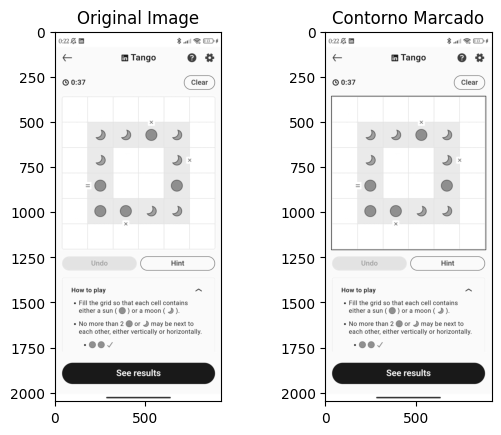

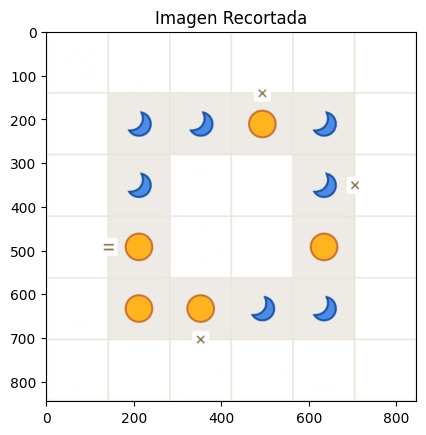

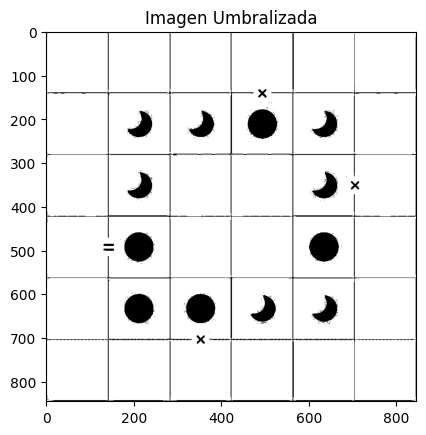

In [4]:
contours, _ = cv2.findContours(thresh1, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)

marked = np.copy(image)
cropped = np.copy(image_og)
if len(contours) != 0:
    # Encontrar el mayor contorno (c) por el area
    c = max(contours, key=cv2.contourArea)
    # Extraer ese contorno, no es el que queremos
    contours = filter(lambda contour: contour.shape != c.shape, contours)
    print(contours)
    c = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)

    # Dibujamos un cuadrado sobre el contorno deseado
    cv2.rectangle(marked, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cropped = cropped[y + 3 : (y + h - 3), x + 3 : (x + w - 3)]
    cropped_gray = cv2.cvtColor(cropped, cv2.COLOR_RGB2GRAY)
    _, threshold = cv2.threshold(
        cropped_gray, 230, 255, cv2.THRESH_BINARY
    )  # Binarización
# show the images
plt.subplot(121)
plt.imshow(image, cmap="gray")
plt.title("Original Image")

plt.subplot(122)
plt.imshow(marked, cmap="gray")
plt.title("Contorno Marcado")
plt.show()

plt.imshow(cropped)
plt.title("Imagen Recortada")
plt.show()
plt.imshow(threshold, cmap="gray")
plt.title("Imagen Umbralizada")
plt.show()

# Ahora necesitamos poder sacar los cuadrados individuales de la imagen
### Para ello usamos la siguiente función

In [5]:
def getCuadrados(image):
    height, width = image.shape

    cuadrados = []

    for i in range(0, 6):

        fila = []

        for j in range(0, 6):
            l = int(i * (width / 6))
            r = int((i + 1) * (width / 6))
            t = int(j * (height / 6))
            b = int((j + 1) * (height / 6))

            cuadrado = image[t:b, l:r]
            fila.append(cuadrado)

        cuadrados.append(fila)

    return cuadrados

### Y sacamos los cuadrados individuales

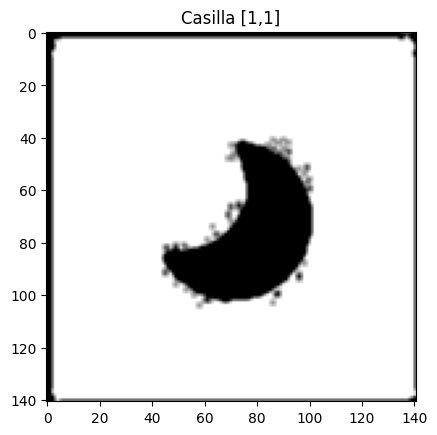

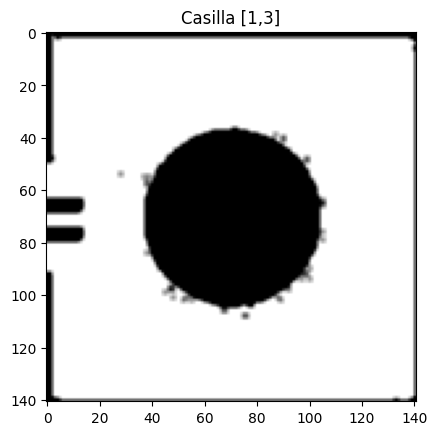

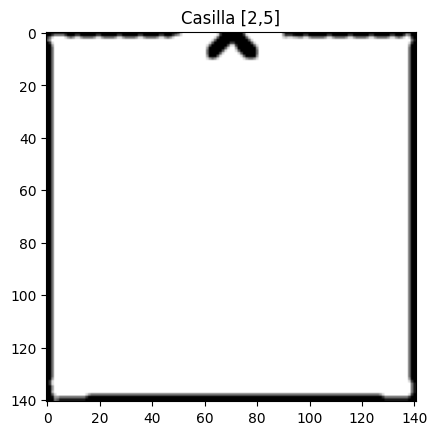

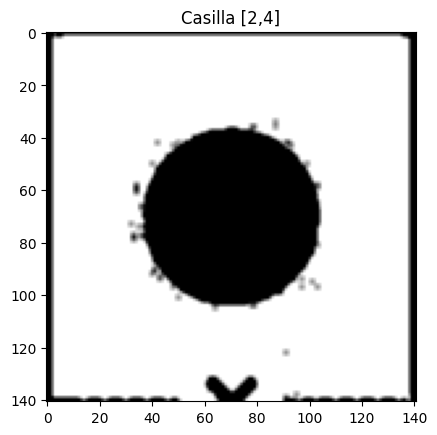

In [6]:
smoothed = gaussian_smoothing(threshold, 1, 1)  # Nunca se está demasiado seguro
cuadrados = getCuadrados(smoothed)
plt.imshow(cuadrados[1][1], cmap="gray")
plt.title("Casilla [1,1]")
plt.show()
plt.imshow(cuadrados[1][3], cmap="gray")
plt.title("Casilla [1,3]")
plt.show()
plt.imshow(cuadrados[2][5], cmap="gray")
plt.title("Casilla [2,5]")
plt.show()
plt.imshow(cuadrados[2][4], cmap="gray")
plt.title("Casilla [2,4]")
plt.show()

### Esta función nos sirve más adelante para eliminar toda la información de los bordes de los cuadrados que no sea crucial

In [7]:
def eliminarBordes(image):
    # Dibujar un rectangulo en todos los lados menos las localizaciones de las posibles X o =

    inicios = [
        (0, 0),
        (0, 0),
        (0, 85),
        (85, 0),
        (130, 85),
        (85, 130),
        (0, 130),
        (130, 0),
    ]
    finales = [
        (10, 55),
        (55, 10),
        (10, 140),
        (140, 10),
        (140, 140),
        (140, 140),
        (55, 140),
        (140, 55),
    ]
    for i in range(0, 8):
        image = cv2.rectangle(image, inicios[i], finales[i], (255, 255, 255), -1)

# Análisis
### En Base al índice devuelto al hacer la NCC con las plantillas, determinamos los modificadores de la casilla

In [8]:
def getModificador(i):
    izq = der = arr = aba = 0
    if i == 0:
        aba = 1
    elif i == 1:
        izq = 1
        aba = 1
    elif i == 2:
        der = 1
        aba = 1
    elif i == 3:
        aba = 1
        arr = -1
    elif i == 4:
        izq = 1
    elif i == 5:
        izq = 1
        aba = -1
    elif i == 6:
        izq = 1
        arr = -1
    elif i == 7:
        der = 1
    elif i == 8:
        der = 1
        aba = -1
    elif i == 9:
        der = 1
        arr = -1
    elif i == 10:
        arr = 1
    elif i == 11:
        arr = 1
        izq = 1
    elif i == 12:
        arr = 1
        der = 1
    elif i == 13:
        arr = 1
        aba = -1
        # El catorce es el caso "normal"
    elif i == 15:
        aba = -1
    elif i == 16:
        aba = -1
        izq = -1
    elif i == 17:
        aba = -1
        der = -1
    elif i == 18:
        izq = -1
    elif i == 19:
        der = -1
    elif i == 20:
        arr = -1
    elif i == 21:
        arr = -1
        izq = -1
    elif i == 22:
        arr = -1
        der = -1
    else:
        izq = 0
        der = 0
        arr = 0
        aba = 0
    return [izq, der, arr, aba]

### Determinamos el símbolo del cuadrado

In [9]:
def getNCC(c):
    tipo = 0
    # Primero comprobamos si es Sol, luna o en blanco
    eliminarBordes(c)
    bTemplate = cv2.imread(images_path + "tiles/blank.jpeg")
    bTemplate = cv2.cvtColor(bTemplate, cv2.COLOR_BGR2GRAY)
    mTemplate = cv2.imread(images_path + "tiles/moon.jpeg")
    mTemplate = cv2.cvtColor(mTemplate, cv2.COLOR_BGR2GRAY)
    sTemplate = cv2.imread(images_path + "tiles/sun.jpeg")
    sTemplate = cv2.cvtColor(sTemplate, cv2.COLOR_BGR2GRAY)

    nccB = cv2.matchTemplate(c, bTemplate, cv2.TM_CCORR_NORMED)
    nccM = cv2.matchTemplate(c, mTemplate, cv2.TM_CCORR_NORMED)
    nccS = cv2.matchTemplate(c, sTemplate, cv2.TM_CCORR_NORMED)
    vB = np.amax(nccB)
    vM = np.amax(nccM)
    vS = np.amax(nccS)

    if vB > vM and vB > vS:
        tipo = 3
    elif vM > vB and vM > vS:
        tipo = 2
    elif vS > vB and vS > vM:
        tipo = 1
    return tipo

## Esta función nos devuelve información sobre el cuadrado analizado  
### Código numérico de los tipos:
#### [relleno][izquierda][derecha][arriba][abajo][valorNCC]
#### 1 = Sol, 2 = Luna, 3 = Desconocido (en blanco)
#### 1 = Igual, -1 = Distinto, 0 = Vacío

In [10]:
def getTipo(c, col, fil):
    tipo = getNCC(c)
    # Una vez extraído el tipo de la casilla, podemos eliminar el posible sol o luna para poder comprobar sus bordes
    ct = np.copy(c)
    # Si es un Sol o una Luna, vamos a tapar el icono para que funcione mejor la NCC
    if tipo != 3:
        ct = cv2.rectangle(ct, (18, 18), (130, 130), (255, 255, 255), -1)

    path = glob.glob(images_path + "tiles/Blanks/*.jpeg")
    i = 0
    index = 0
    valor = 0.0
    ncc_arr = []
    for img in path:
        t = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
        t = gaussian_smoothing(t, 1, 1)
        eliminarBordes(t)
        _, t = cv2.threshold(t, 232, 255, cv2.THRESH_BINARY)  # Binarización
        ncc = cv2.matchTemplate(ct, t, cv2.TM_CCORR_NORMED)
        value = np.sum(ncc)
        ncc_arr.append(value)
        maxV = np.amax(ncc_arr)
        if valor < maxV:
            valor = maxV
            i = index
        index = index + 1

    izq, der, arr, aba = getModificador(i)
    #Si la casilla está en alguno de los bordes, hay modificadores que sí o sí no va a poder tener
    #Por si acaso, nos aseguramos de que no se de un falso positivo
    if fil == 0:
        arr = 0
    if col == 0:
        izq = 0
    if fil == 5:
        aba = 0
    if col == 5:
        der = 0
    return [tipo, izq, der, arr, aba, valor]

## Aquí recorremos el array de cuadrados analizando sus datos y construyendo el array de tipos

In [11]:
def constructTipos(cuadrados):
    tipos = []

    for f in range(0, 6):
        fila = []
        for c in range(0, 6):
            cuad = cuadrados[c][f]
            tipo = getTipo(cuad, c, f)
            fila.append(tipo)
        tipos.append(fila)
    return tipos

In [12]:
tipos = constructTipos(cuadrados)
print(tipos)

[[[3, 0, 0, 0, 0, np.float32(1.99092)], [3, 0, 0, 0, 0, np.float32(1.9908545)], [3, 0, 0, 0, 0, np.float32(1.993216)], [3, 0, 0, 0, 0, np.float32(1.9905486)], [3, 0, 0, 0, 0, np.float32(1.9914999)], [3, 0, 0, 0, 0, np.float32(1.9906031)]], [[3, 0, 0, 0, 0, np.float32(0.9952378)], [2, 0, 0, 0, 0, np.float32(0.995419)], [2, 0, 0, 0, 0, np.float32(0.9960846)], [1, 0, 0, -1, 0, np.float32(0.99421334)], [2, 0, 0, 0, 0, np.float32(0.99548477)], [3, 0, 0, 0, 0, np.float32(0.99530554)]], [[3, 0, 0, 0, 0, np.float32(0.99521136)], [2, 0, 0, 0, 0, np.float32(0.9961536)], [3, 0, 0, 0, 0, np.float32(0.9965488)], [3, 0, 0, 0, 0, np.float32(0.9953586)], [2, 0, 0, 0, 0, np.float32(0.99496526)], [3, -1, 0, 0, 0, np.float32(0.99505126)]], [[3, 0, 1, 0, 0, np.float32(0.99529713)], [1, -1, 0, 0, 0, np.float32(0.9949009)], [3, 0, 0, 0, 0, np.float32(0.99630487)], [3, 0, 0, 0, 0, np.float32(0.9954116)], [1, 0, 0, 0, 0, np.float32(0.99548477)], [3, 0, 0, 0, 0, np.float32(0.99492574)]], [[3, 0, 0, 0, 0, np.fl

### Esta función se asegura de que no haya parejas de casillas juntas con modificadores discordantes

In [13]:
def congruenciaTipos(tipos):
    # Comprobamos discordancias
    for f in range(0, 6):
        for c in range(0, 6):
            if c < 5:
                # Si no tienen el mismo modificador hacia la derecha
                if tipos[f][c][2] != tipos[f][c + 1][1]:
                    # Comprobamos cuál tiene mayor valor NCC
                    if tipos[f][c][5] > tipos[f][c + 1][5]:
                        tipos[f][c + 1][1] = tipos[f][c][2]
                    elif tipos[f][c + 1][5] > tipos[f][c][5]:
                        tipos[f][c][2] = tipos[f][c + 1][1]
            if c > 0:
                # Si no tienen el mismo modificador hacia la izquierda
                if tipos[f][c][1] != tipos[f][c - 1][2]:
                    # Comprobamos cuál tiene mayor valor NCC
                    if tipos[f][c][5] > tipos[f][c - 1][5]:
                        tipos[f][c][2] = tipos[f][c][1]
                    elif tipos[f][c - 1][5] > tipos[f][c][5]:
                        tipos[f][c][1] = tipos[f][c - 1][2]
            if f < 5:
                # Si no tienen el mismo modificador hacia abajo
                if tipos[f][c][4] != tipos[f + 1][c][3]:
                    # Comprobamos cuál tiene mayor valor NCC
                    if tipos[f][c][5] > tipos[f + 1][c][5]:
                        tipos[f + 1][c][3] = tipos[f][c][4]
                    elif tipos[f + 1][c][5] > tipos[f][c][5]:
                        tipos[f][c][4] = tipos[f + 1][c][3]
            if f > 0:
                # Si no tienen el mismo modificador hacia arriba
                if tipos[f][c][3] != tipos[f - 1][c][4]:
                    # Comprobamos cuál tiene mayor valor NCC
                    if tipos[f][c][5] > tipos[f - 1][c][5]:
                        tipos[f - 1][c][4] = tipos[f][c][3]
                    elif tipos[f - 1][c][5] > tipos[f][c][5]:
                        tipos[f][c][3] = tipos[f - 1][c][4]
    tipos_sin_v = []
    for f in range(0, 6):
        col = []
        for c in range(0, 6):
            col.append(
                [
                    tipos[f][c][0],
                    tipos[f][c][1],
                    tipos[f][c][2],
                    tipos[f][c][3],
                    tipos[f][c][4],
                ]
            )
        tipos_sin_v.append(col)
    return tipos_sin_v

## Nos aseguramos de que los modificadores tengan sentido

In [14]:
tipos = congruenciaTipos(tipos)
print(tipos)

[[[3, 0, 0, 0, 0], [3, 0, 0, 0, 0], [3, 0, 0, 0, 0], [3, 0, 0, 0, 0], [3, 0, 0, 0, 0], [3, 0, 0, 0, 0]], [[3, 0, 0, 0, 0], [2, 0, 0, 0, 0], [2, 0, 0, 0, 0], [1, 0, 0, 0, 0], [2, 0, 0, 0, 0], [3, 0, 0, 0, 0]], [[3, 0, 0, 0, 0], [2, 0, 0, 0, 0], [3, 0, 0, 0, 0], [3, 0, 0, 0, 0], [2, 0, -1, 0, 0], [3, -1, 0, 0, 0]], [[3, 0, 1, 0, 0], [1, 1, 0, 0, 0], [3, 0, 0, 0, 0], [3, 0, 0, 0, 0], [1, 0, 0, 0, 0], [3, 0, 0, 0, 0]], [[3, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [2, 0, 0, 0, 0], [2, 0, 0, 0, 0], [3, 0, 0, 0, 0]], [[3, 0, 0, 0, 0], [3, 0, 0, 0, 0], [3, 0, 0, 0, 0], [3, 0, 0, 0, 0], [3, 0, 0, 0, 0], [3, 0, 0, 0, 0]]]


## Estas dos funciones nos sirven para tener en cuenta qué símbolos ya han sido determinados y no deben cambiar

In [15]:
# Guardamos las posiciones de los símbolos iniciales
def simbolosIniciales(matriz):
    init_pos = []
    for f in range(0, 6):
        for c in range(0, 6):
            if matriz[f][c] != 0:
                init_pos.append([f, c])
    # print(init_pos)
    return init_pos


def modificable(f, c):
    if [f, c] in init_pos:
        return False
    else:
        return True

### Función que construye la matriz base sobre la que se va a resolver

In [16]:
# Matriz del estado original del tablero
def construirMatriz(tipos):
    matriz = np.zeros((6, 6))
    for c in range(0, 6):
        for f in range(0, 6):
            if tipos[c][f][0] != 3:
                matriz[c, f] = tipos[c][f][0]
            else:
                matriz[c, f] = 0
    return matriz

In [17]:
matriz = construirMatriz(tipos)
print(matriz)

[[0. 0. 0. 0. 0. 0.]
 [0. 2. 2. 1. 2. 0.]
 [0. 2. 0. 0. 2. 0.]
 [0. 1. 0. 0. 1. 0.]
 [0. 1. 1. 2. 2. 0.]
 [0. 0. 0. 0. 0. 0.]]


# Resolución
Habiendo hecho todo eso, podemos finalmente *resolver*  
El algoritmo funciona de la siguiente manera:  
## Mientras que alguna de las filas o columnas no sume nueve (2 * 3 + 1 * 3), seguirá realizando los pasos.  
 -  Comprobar los modificadores junto a los símbolos iniciales: Si hay en init_pos algúna casilla con un modificador hacia una casilla en blanco, podemos resolver esa casilla.
 -  Comprobar los = a una casilla de los símbolos iniciales: Si hay un igual a 1 casilla de distancia de una casilla con símbolo, sabemos que esa y a la que conecta el igual tienen que ser del símbolo contrario.
 -  Comprobar que no haya tres símbolos iguales seguidos: Si hay dos casillas con el mismo símbolo seguidas, la siguiente tiene que tener el símbolo contrario. Del mismo modo si hay dos casillas del mísmo símbolo separadas por una sola casilla, esa debe ser del símbolo contrario.
 -  Rellenar las filas o columnas en las que sólo queda una casilla: Si sólo queda una casilla vacía en una fila o columna, podemos determinar su símbolo contando las ocurrencias de Soles y Lunas en esa misma fila o columna.

In [18]:
# Y resolvemos
m = matriz
suma_fila = np.sum(m, axis=1)
suma_fila0 = suma_fila[0]
suma_fila1 = suma_fila[1]
suma_fila2 = suma_fila[2]
suma_fila3 = suma_fila[3]
suma_fila4 = suma_fila[4]
suma_fila5 = suma_fila[5]
suma_col = np.sum(m, axis=0)
suma_col0 = suma_col[0]
suma_col1 = suma_col[1]
suma_col2 = suma_col[2]
suma_col3 = suma_col[3]
suma_col4 = suma_col[4]
suma_col5 = suma_col[5]
while (
    suma_fila0 != 9
    or suma_fila1 != 9
    or suma_fila2 != 9
    or suma_fila3 != 9
    or suma_fila4 != 9
    or suma_fila5 != 9
    or suma_col0 != 9
    or suma_col1 != 9
    or suma_col2 != 9
    or suma_col3 != 9
    or suma_col4 != 9
    or suma_col5 != 9
):
    # Paso 1: Comprobar los modificadores de las casillas con símbolos iniciales
    init_pos = simbolosIniciales(m)
    n_cas = len(init_pos)
    n_cas_aux = 0
    while n_cas != n_cas_aux:
        for i in range(0, n_cas):
            f, c = init_pos[i]
            if m[f][c] != 0:
                if tipos[f][c][1] == 1 and modificable(f, c - 1):
                    m[f][c - 1] = m[f][c]
                elif tipos[f][c][1] == -1 and modificable(f, c - 1):
                    m[f][c - 1] = 3 - m[f][c]
                if tipos[f][c][2] == 1 and modificable(f, c + 1):
                    m[f][c + 1] = m[f][c]
                elif tipos[f][c][2] == -1 and modificable(f, c + 1):
                    m[f][c + 1] = 3 - m[f][c]

                if tipos[f][c][3] == 1 and modificable(f - 1, c):
                    m[f - 1][c] = m[f][c]
                elif tipos[f][c][3] == -1 and modificable(f - 1, c):
                    m[f - 1][c] = 3 - m[f][c]
                if tipos[f][c][4] == 1 and modificable(f + 1, c):
                    m[f + 1][c] = m[f][c]
                elif tipos[f][c][4] == -1 and modificable(f + 1, c):
                    m[f + 1][c] = 3 - m[f][c]
        n_cas_aux = n_cas
        init_pos = simbolosIniciales(m)
        n_cas = len(init_pos)
        # Paso 2: Comrpobar los = a una casilla de distancia de los símbolos iniciales
    init_pos = simbolosIniciales(m)
    n_cas = len(init_pos)
    n_cas_aux = 0
    while n_cas != n_cas_aux:
        for i in range(0, n_cas):
            f, c = init_pos[i]
            if m[f][c] != 0:
                if (
                    c < 4
                    and tipos[f][c + 1][2] == 1
                    and modificable(f, c + 1)
                    and modificable(f, c + 2)
                ):
                    m[f][c + 1] = m[f][c + 2] = 3 - m[f][c]
                elif (
                    c > 1
                    and tipos[f][c - 1][1] == 1
                    and modificable(f, c - 1)
                    and modificable(f, c - 2)
                ):
                    m[f][c - 1] = m[f][c - 2] = 3 - m[f][c]
                if (
                    f < 4
                    and tipos[f + 1][c][4] == 1
                    and modificable(f + 1, c)
                    and modificable(f + 2, c)
                ):
                    m[f + 1][c] = m[f + 2][c] == 3 - m[f][c]
                elif (
                    f > 1
                    and tipos[f - 1][c][3] == 1
                    and modificable(f - 1, c)
                    and modificable(f - 2, c)
                ):
                    m[f - 1][c] = m[f - 2][c] == 3 - m[f][c]
        n_cas_aux = n_cas
        init_pos = simbolosIniciales(m)
        n_cas = len(init_pos)
        # Paso 3: No puede haber tres símbolos iguales seguidos
    init_pos = simbolosIniciales(m)
    n_cas = len(init_pos)
    n_cas_aux = 0
    init_pos = simbolosIniciales(m)
    n_cas = len(init_pos)
    n_cas_aux = 0
    while n_cas != n_cas_aux:
        cambios = 0
        for i in range(0, n_cas):
            f, c = init_pos[i]
            if m[f][c] != 0:
                # Si hay dos iguales hacia la derecha
                if c < 4 and m[f][c] == m[f][c + 1] and modificable(f, c + 2):
                    m[f][c + 2] = 3 - m[f][c]
                # Si hay dos iguales hacia la izquierda
                if c > 1 and m[f][c] == m[f][c - 1] and modificable(f, c - 2):
                    m[f][c - 2] = 3 - m[f][c]
                # Si hay dos iguales hacia abajo
                if f < 4 and m[f][c] == m[f + 1][c] and modificable(f + 2, c):
                    m[f + 2][c] = 3 - m[f][c]
                # Si hay dos iguales hacia la izquierda
                if f > 1 and m[f][c] == m[f - 1][c] and modificable(f - 2, c):
                    m[f - 2][c] = 3 - m[f][c]
        n_cas_aux = n_cas
        init_pos = simbolosIniciales(m)
        n_cas = len(init_pos)
        # Continuación del paso 3
    init_pos = simbolosIniciales(m)
    n_cas = len(init_pos)
    n_cas_aux = 0
    while n_cas != n_cas_aux:
        cambios = 0
        for i in range(0, n_cas):
            f, c = init_pos[i]
            if m[f][c] != 0:
                # Si hay dos iguales con un espacio blanco hacia la derecha
                if c < 3 and m[f][c] == m[f][c + 2] and modificable(f, c + 1):
                    m[f][c + 1] = 3 - m[f][c]
                # Si hay dos iguales con un espacio blanco hacia la izquierda
                if c > 2 and m[f][c] == m[f][c - 2] and modificable(f, c - 1):
                    m[f][c - 1] = 3 - m[f][c]
                # Si hay dos iguales con un espacio blanco hacia abajo
                if f < 3 and m[f][c] == m[f + 2][c] and modificable(f + 1, c):
                    m[f + 1][c] = 3 - m[f][c]
                # Si hay dos iguales con un espacio blanco hacia la izquierda
                if f > 2 and m[f][c] == m[f - 2][c] and modificable(f - 1, c):
                    m[f - 1][c] = 3 - m[f][c]
        n_cas_aux = n_cas
        init_pos = simbolosIniciales(m)
        n_cas = len(init_pos)
        # Paso 4: Rellenar las filas o columnas en las que ya sólo queda una casilla
    init_pos = simbolosIniciales(m)
    n_cas = len(init_pos)
    n_cas_aux = 0
    while n_cas != n_cas_aux:
        cambios = 0
        for f in range(0, 6):
            for c in range(0, 6):
                if m[f][c] == 0:
                    unique, f_cnt = np.unique(m[0:, c], return_counts=True)
                    unique, c_cnt = np.unique(m[f, 0:], return_counts=True)
                    if len(f_cnt) == 3:
                        # si hay ya tres soles en la fila
                        if f_cnt[1] == 3:
                            m[f][c] = 2
                        elif f_cnt[2] == 3:
                            m[f][c] = 1
                    if len(c_cnt) == 3:
                        # si hay ya tres soles en la fila
                        if c_cnt[1] == 3:
                            m[f][c] = 2
                        elif c_cnt[2] == 3:
                            m[f][c] = 1
        n_cas_aux = n_cas
        init_pos = simbolosIniciales(m)
        n_cas = len(init_pos)
    suma_fila = np.sum(m, axis=1)
    suma_fila0 = suma_fila[0]
    suma_fila1 = suma_fila[1]
    suma_fila2 = suma_fila[2]
    suma_fila3 = suma_fila[3]
    suma_fila4 = suma_fila[4]
    suma_fila5 = suma_fila[5]

    suma_col = np.sum(m, axis=0)
    suma_col0 = suma_col[0]
    suma_col1 = suma_col[1]
    suma_col2 = suma_col[2]
    suma_col3 = suma_col[3]
    suma_col4 = suma_col[4]
    suma_col5 = suma_col[5]

print("Solucion del Tango:\n", m)

Solucion del Tango:
 [[2. 1. 1. 2. 1. 2.]
 [1. 2. 2. 1. 2. 1.]
 [2. 2. 1. 1. 2. 1.]
 [1. 1. 2. 2. 1. 2.]
 [2. 1. 1. 2. 2. 1.]
 [1. 2. 2. 1. 1. 2.]]


# ¡Perita!
## Una vez hemos obtenido la matriz resuelta, podemos construir una imagen del tablero completado para el usuario

In [19]:
def generateImage(m):
    sun = cv2.imread(images_path + "tiles/sun_w.jpeg")
    sun = cv2.cvtColor(sun, cv2.COLOR_BGR2RGB)
    moon = cv2.imread(images_path + "tiles/moon_w.jpeg")
    moon = cv2.cvtColor(moon, cv2.COLOR_BGR2RGB)
    imagen_final = []
    for f in range(0, 6):
        col = []
        for c in range(0, 6):
            if m[f, c] == 1:
                col.append(sun)
            elif m[f, c] == 2:
                col.append(moon)
        col_img = np.hstack(col)
        imagen_final.append(col_img)

    imagen = np.vstack(imagen_final)
    return imagen

Ahora vamos a construir y mostrar el tablero resuelto

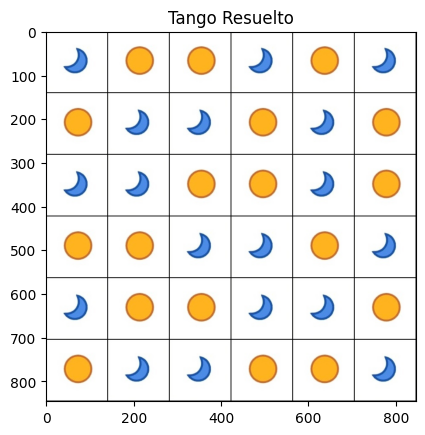

In [20]:
img = generateImage(m)
plt.imshow(img)
plt.title("Tango Resuelto")
plt.show()